In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

import json
from collections import defaultdict as dd

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [67]:
def read_data(file):
    with open(file+'.json') as f:
        data = json.load(f)

        dataframe = dd(list)
        for feature in data['features']:
            for column, value in feature['properties'].items():
                dataframe[column].append(value)

    return pd.DataFrame(dataframe)
    
income = read_data('data_income')
income.columns = [ 'GCCSA', 'MEDIAN_INCOME', 'AREA']

edu_emp = read_data('data_education_employment')
edu_emp.columns = ['UNEMPLOYMENT_RATE', 'TOTAL', 'AREA', 'YEAR', 'BACHELORS', 
                   'POST_GRAD', 'DIPLOMA', 'GCCSA', 'CERT', 'NA', 'CENSUS_CERT']

data = pd.merge(income, edu_emp, on=['AREA', 'GCCSA']).drop('GCCSA', axis=1)
data = data[(data.AREA.str.contains('Greater')) | (data.AREA == 'Australian Capital Territory')].reset_index(drop=True)

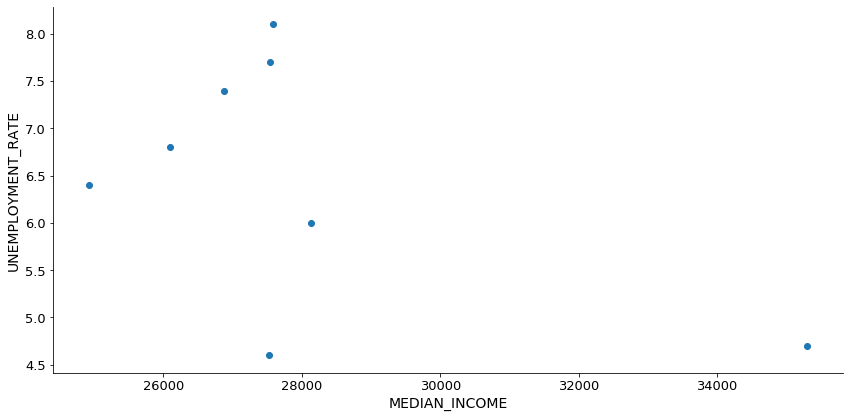

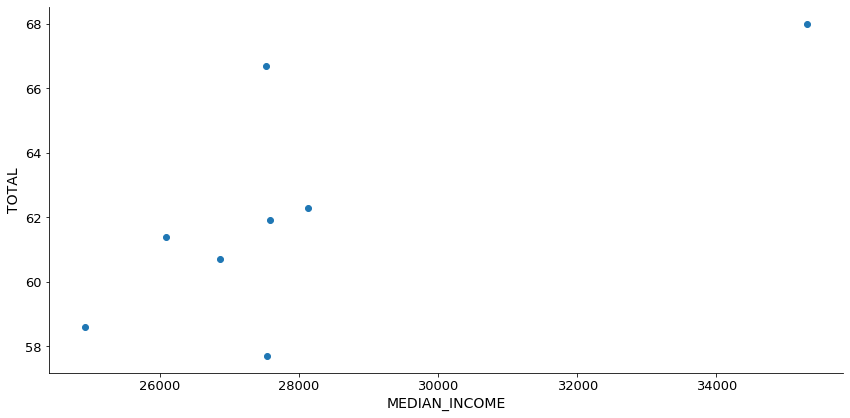

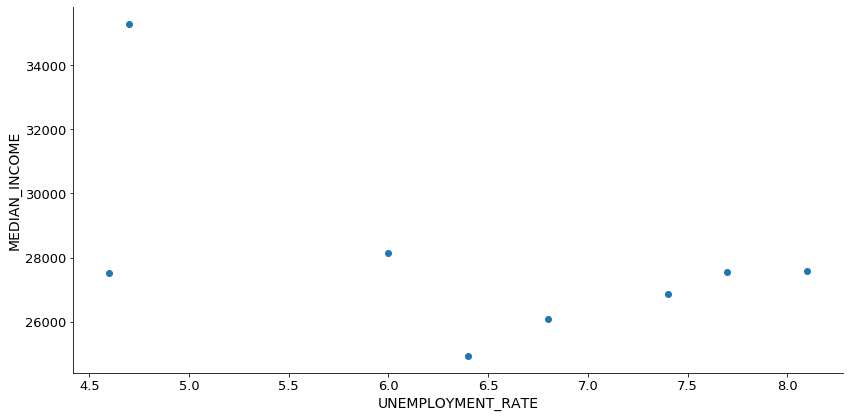

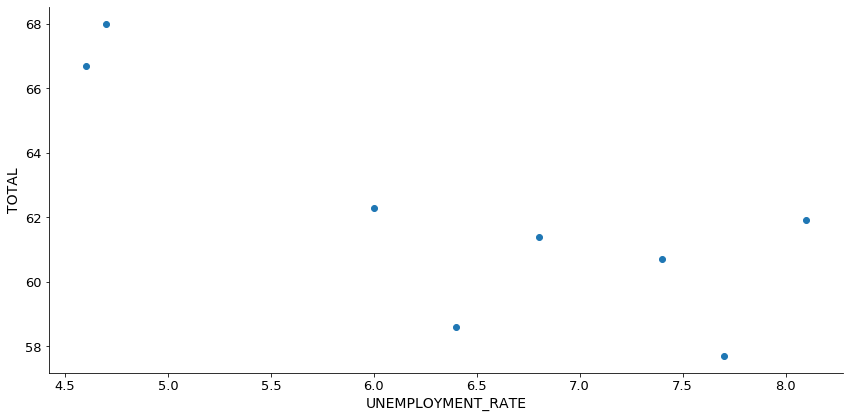

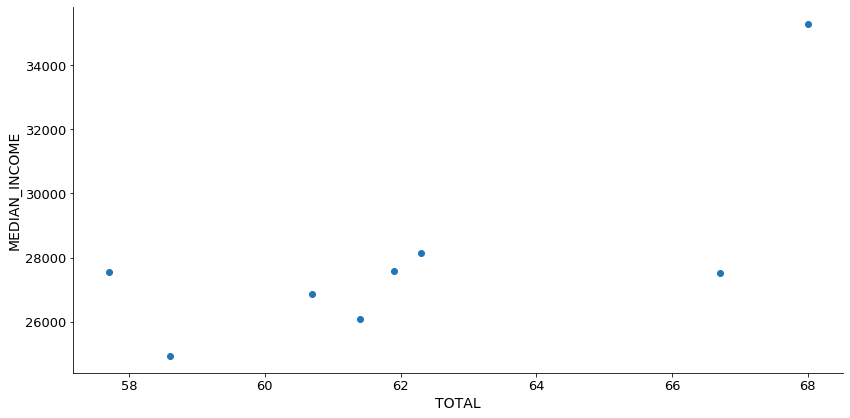

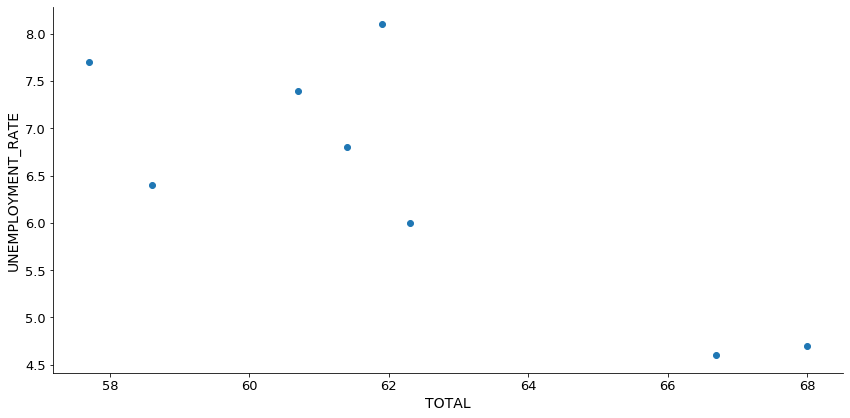

In [68]:
def graph(x, y, save=False):
    
    fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
    
    ax.scatter(x, y)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    
    sns.despine()
    if save:
        plt.savefig(f'{x.name}_{y.name}.png', dpi=2*fig.dpi)
    plt.show()

for col1 in ['MEDIAN_INCOME', 'UNEMPLOYMENT_RATE', 'TOTAL']:
    for col2 in ['MEDIAN_INCOME', 'UNEMPLOYMENT_RATE', 'TOTAL']:
        if col1 != col2:
            graph(data[col1], data[col2])